In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
# from statsmodels.tools.sm_exceptions import ConvergenceWarning
# warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

In [2]:
df_raw = pd.read_csv('zillow_data.csv')
df_raw.head()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [3]:
# Import zipcode database to pair with data
df_Zipcode = pd.read_csv('zip_code_database.csv')

In [4]:
# Rename RegionName to Zipcode to merge data from zip code import
df_raw.rename(columns={'RegionName': 'Zipcode'}, inplace = True)

In [5]:
# Drop other columns and keep Zipcode (for merge), Lat/Long, and estimated Population
df_Zipcode.rename(columns={'zip':'Zipcode'}, inplace = True)
df_Zipcode = df_Zipcode[['Zipcode', 'latitude', 'longitude', 'irs_estimated_population' ]]
df_Zipcode.head()

,Zipcode,latitude,longitude,irs_estimated_population
0,501,40.81,-73.04,562
1,544,40.81,-73.04,0
2,601,18.16,-66.72,0
3,602,18.38,-67.18,0
4,603,18.43,-67.15,0


In [6]:
df = df_raw.merge(df_Zipcode, on = 'Zipcode')
df.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1009600,1013300,1018700,1024400,1030700,1033800,1030600,41.94,-87.65,54760
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,314100,315000,316600,318100,319600,321100,321800,33.17,-96.70,56810
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320400,320800,321200,321200,323000,326900,329900,29.74,-95.83,125330
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1291500,1296600,1299000,1302700,1306400,1308500,1307000,41.92,-87.65,52800
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120300,120300,120300,120300,120500,121000,121500,31.78,-106.30,99590


In [7]:
#Dividing zipcodes into region 
df_East = df[df_raw.Zipcode < 50000]
df_Central = df[(df_raw.Zipcode >= 50000) & (df_raw.Zipcode < 80000) ]
df_West = df[(df.Zipcode >= 80000)]
#West coast** 
df_West.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3799700,3793900,3778700,3770800,3763100,3779800,3813500,37.79,-122.42,39680
15,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,152500.0,152600.0,152600.0,...,594700,598500,601300,602800,606100,612400,616200,33.91,-118.34,85010
27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,405400,408600,410900,413700,417900,424300,430100,38.01,-121.91,89590
30,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1903900,1907500,1922100,1952400,1974500,1975900,1966900,34.11,-118.36,35600
56,94748,85032,Phoenix,AZ,Phoenix,Maricopa,57,95400.0,95800.0,96200.0,...,259500,260700,261900,263100,264100,265400,266400,33.62,-112.00,57380


In [8]:
# California Data frame
cali_df_uf = df_West[(df_West['State'] == 'CA')]
cali_df_uf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224 entries, 9 to 14712
Columns: 275 entries, RegionID to irs_estimated_population
dtypes: float64(221), int64(50), object(4)
memory usage: 2.6+ MB


In [9]:
print(cali_df_uf.shape)
cali_df_uf.head()

(1224, 275)


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3799700,3793900,3778700,3770800,3763100,3779800,3813500,37.79,-122.42,39680
15,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,152500.0,152600.0,152600.0,...,594700,598500,601300,602800,606100,612400,616200,33.91,-118.34,85010
27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,405400,408600,410900,413700,417900,424300,430100,38.01,-121.91,89590
30,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1903900,1907500,1922100,1952400,1974500,1975900,1966900,34.11,-118.36,35600
64,97711,94501,Alameda,CA,San Francisco,Alameda,65,222400.0,222300.0,222400.0,...,1000000,1009900,1021000,1032400,1042000,1053000,1059700,37.77,-122.27,56900


## Narrowing down results 
### 1) Population Density

In [10]:
cali_df_uf['irs_estimated_population'].mean()

27356.438725490196

In [11]:
cali_df_uf['irs_estimated_population'].median()

25565.0

In [12]:
cali_dff = cali_df_uf[(cali_df_uf.irs_estimated_population >= 28000)]

### 2) Price Percentile 

In [13]:
cali_dff['yr_avg']=cali_dff.iloc[:,-12:].mean(skipna=True, axis=1)
#Get zipcodes with an average value 1 decile above the median and 1.5 deciles below.
print(cali_dff['yr_avg'].describe(),'\n')
#Calculate the 75% cutoff value (1 decile above).
q_75 = cali_dff['yr_avg'].quantile(q=0.75)
print(f'Average Value 75% cutoff value: {round(q_75,2)}')
#Calculate the 25% cutoff value (1.5 deciles below).
q_25 = cali_dff['yr_avg'].quantile(q=0.25)
print(f'Average Value 25% cutoff value: {round(q_25,2)}')
#Get data frame with selected zipcodes.
cali_dff1 = cali_dff[(cali_dff['yr_avg']<q_75) & (cali_dff['yr_avg']>q_25)]
print(f'Amount of zipcodes: {len(cali_dff1)}')

count    5.440000e+02
mean     5.007335e+05
std      3.624352e+05
min      9.349306e+04
25%      2.906666e+05
50%      4.093647e+05
75%      5.722068e+05
max      2.839833e+06
Name: yr_avg, dtype: float64 

Average Value 75% cutoff value: 572206.75
Average Value 25% cutoff value: 290666.58
Amount of zipcodes: 272


<ipython-input-13-e1790964b6dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_dff['yr_avg']=cali_dff.iloc[:,-12:].mean(skipna=True, axis=1)


In [14]:
# After filtering the percentiles
print(cali_dff1.shape)

(272, 276)


In [15]:
cali_dff1['ROI_5'] = round((cali_dff1['2018-04'] - cali_dff1['2010-01'])/ cali_dff1['2010-01'],4)

<ipython-input-15-2addfe29eae5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_dff1['ROI_5'] = round((cali_dff1['2018-04'] - cali_dff1['2010-01'])/ cali_dff1['2010-01'],4)


In [16]:
cali_dff1.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5
15,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,152500.0,152600.0,152600.0,...,601300,602800,606100,612400,616200,33.91,-118.34,85010,457793.797500,0.6999
27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,410900,413700,417900,424300,430100,38.01,-121.91,89590,316700.508333,1.5847
86,96025,90044,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,87,119500.0,119500.0,119400.0,...,404200,409700,414300,418500,421100,33.95,-118.29,78060,309681.305000,1.0940
90,96239,90805,Long Beach,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,91,128300.0,128100.0,127800.0,...,447700,451700,455000,457600,459100,33.86,-118.18,83830,341920.473333,0.7403
93,98325,95630,Folsom,CA,Sacramento,Sacramento,94,190000.0,189300.0,188500.0,...,537200,542400,544600,544100,542900,38.67,-121.14,69990,408717.294167,0.4223


In [17]:
# cali_dff1.sort_values(by=['ROI_5'], ascending = False)

In [18]:
cali_df3 = cali_dff1.nlargest(10, 'ROI_5')
cali_df3.sort_values(by=['ROI_5'], ascending = False)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5
1853,97850,94804,Richmond,CA,San Francisco,Contra Costa,1854,171300.0,170300.0,169400.0,...,448000,452400,459200,471800,483100,37.92,-122.34,38610,342635.465000,1.8434
1477,97803,94601,Oakland,CA,San Francisco,Alameda,1478,114600.0,114500.0,114500.0,...,535800,546900,555000,562000,566700,37.77,-122.21,45290,406675.463333,1.7024
310,97717,94509,Antioch,CA,San Francisco,Contra Costa,311,142500.0,141500.0,140400.0,...,390100,393600,397800,403500,408700,37.99,-121.81,59890,298875.515000,1.5883
27,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,410900,413700,417900,424300,430100,38.01,-121.91,89590,316700.508333,1.5847
1681,97808,94606,Oakland,CA,San Francisco,Alameda,1682,120400.0,120300.0,120300.0,...,663100,676500,683700,691700,696800,37.78,-122.24,30770,496223.795000,1.5846
2723,96655,92113,San Diego,CA,San Diego,San Diego,2724,89700.0,89500.0,89400.0,...,388100,393400,398300,402500,405000,32.69,-117.11,47450,295905.465000,1.5218
3121,97990,95122,San Jose,CA,San Jose,Santa Clara,3122,170800.0,170800.0,170900.0,...,700600,709100,720300,736700,748500,37.33,-121.83,53790,529383.791667,1.4892
2676,97984,95116,San Jose,CA,San Jose,Santa Clara,2677,170600.0,170700.0,171000.0,...,714800,726100,737700,753300,764500,37.35,-121.85,46110,537835.458333,1.4308
1191,95999,90018,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1192,133200.0,132900.0,132400.0,...,640300,643100,646400,652700,658000,34.02,-118.31,40590,482883.809167,1.3610
1469,98153,95376,Tracy,CA,Stockton,San Joaquin,1470,153300.0,153100.0,152900.0,...,417300,419700,423300,427500,429100,37.73,-121.42,50400,317043.025833,1.3487


In [19]:
# #Calculate historical return on investment
# cali_dff1['ROI']= (cali_dff1['2018-04']/cali_dff1['1996-04'])-1
# #Calculate standard deviation of monthly values
# cali_dff1['std']=cali_dff1.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)
# #Calculate historical mean value
# cali_dff1['mean']=cali_dff1.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)
# #Calculate coefficient of variance
# cali_dff1['CV']=cali_dff1['std']/cali_dff1['mean']
# #Show calculated values
# cali_dff1[['RegionName','std','mean','ROI','CV']].head()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


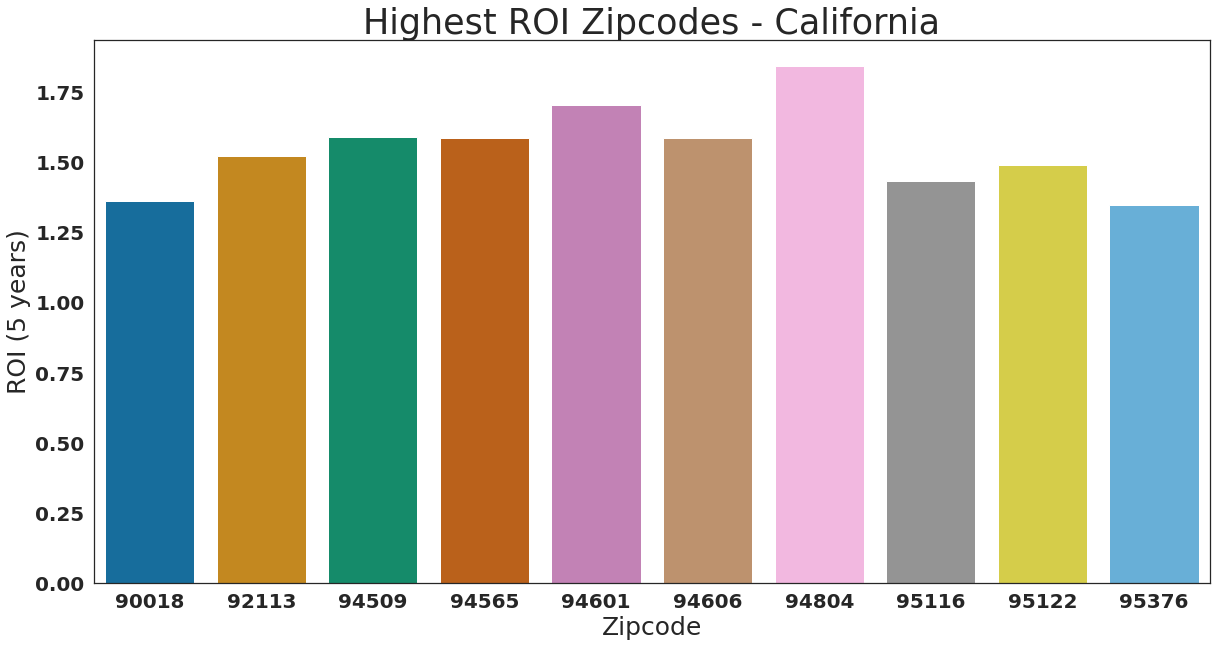

In [81]:

fig, ax = plt.subplots(figsize = (20, 10))
sns.set(style = 'white')
palette = sns.set_palette(sns.color_palette("colorblind"))
p = sns.barplot(x = "Zipcode", y = 'ROI_5', data = cali_df3, color = palette)
p.set_xlabel("Zipcode", fontsize = 25)
p.set_ylabel("ROI (5 years)", fontsize = 25)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
p.set_title("Highest ROI Zipcodes - California", fontsize = 35)

plt.show()

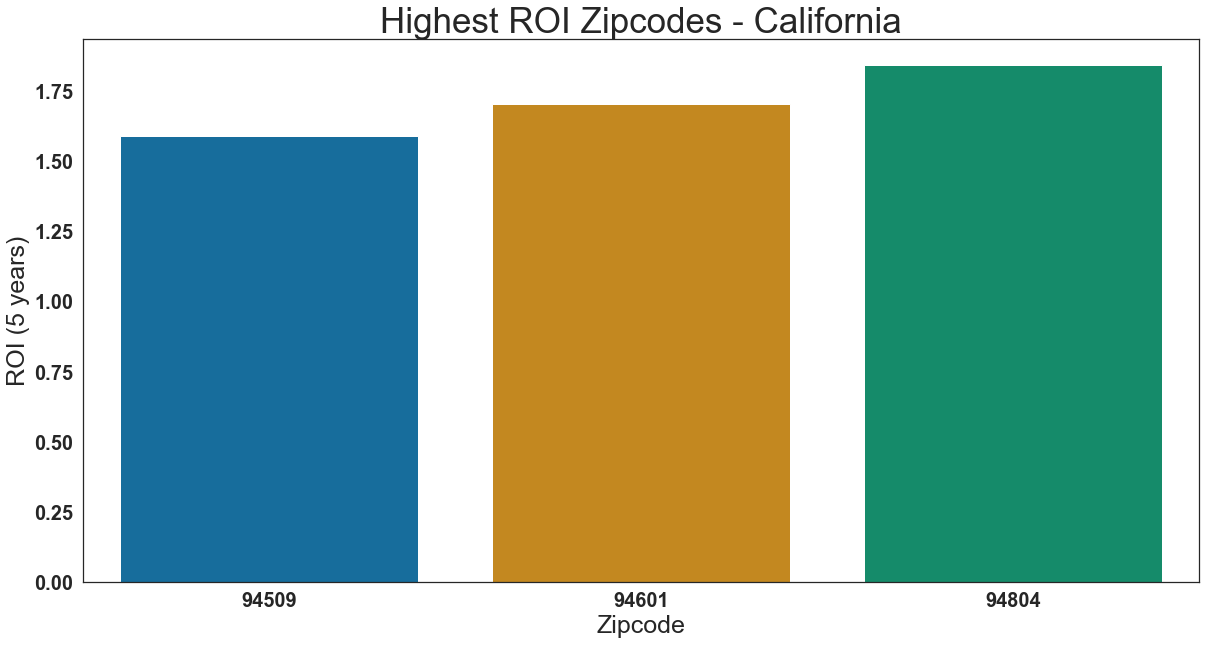

In [82]:

fig, ax = plt.subplots(figsize = (20, 10))
sns.set(style = 'white')
palette = sns.set_palette(sns.color_palette("colorblind"))
p = sns.barplot(x = "Zipcode", y = 'ROI_5', data = cali_df3[:3], color = palette)
p.set_xlabel("Zipcode", fontsize = 25)
p.set_ylabel("ROI (5 years)", fontsize = 25)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
p.set_title("Highest ROI Zipcodes - California", fontsize = 35)

plt.show()

In [22]:
cali_map = folium.Map([36.99, -119.78], zoom_start = 6.3, width = '75%')
for lat, lon in zip(cali_df3['latitude'][:3], cali_df3['longitude'][:3]):
    folium.CircleMarker([lat, lon], radius = 10, color = 'darkred').add_to(cali_map)
cali_map

# Time Series for top 3 zip codes

In [23]:
df94601 = cali_df3[cali_df3['Zipcode']== 94601]
df94601.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,latitude,longitude,irs_estimated_population,yr_avg,ROI_5
1477,97803,94601,Oakland,CA,San Francisco,Alameda,1478,114600.0,114500.0,114500.0,...,535800,546900,555000,562000,566700,37.77,-122.21,45290,406675.463333,1.7024


In [24]:
df94606 = cali_df3[cali_df3['Zipcode']== 94606]

In [25]:
df94804 = cali_df3[cali_df3['Zipcode']== 94804]

In [26]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:-5], format='%Y-%m')

In [27]:
get_datetimes(df94601)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [28]:
get_datetimes(df94606)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [29]:
get_datetimes(df94804)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [30]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [31]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['Zipcode', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName','latitude', 'longitude', 'irs_estimated_population','yr_avg', 'ROI_5']
                                 , var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('Date').aggregate({'value':'mean'}) 

In [32]:
cali_df_uf.shape

(1224, 275)

In [33]:
def melt_data_uf(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['Zipcode', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName','latitude', 'longitude', 'irs_estimated_population']
                                 , var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('Date').aggregate({'value':'mean'}) 

In [34]:
caliuf_melted = melt_data_uf(cali_df_uf)

In [35]:
melted_94601 = melt_data(df94601)
melted_94601
melted_94604 = melt_data(df94606)
melted_94804 = melt_data(df94804)

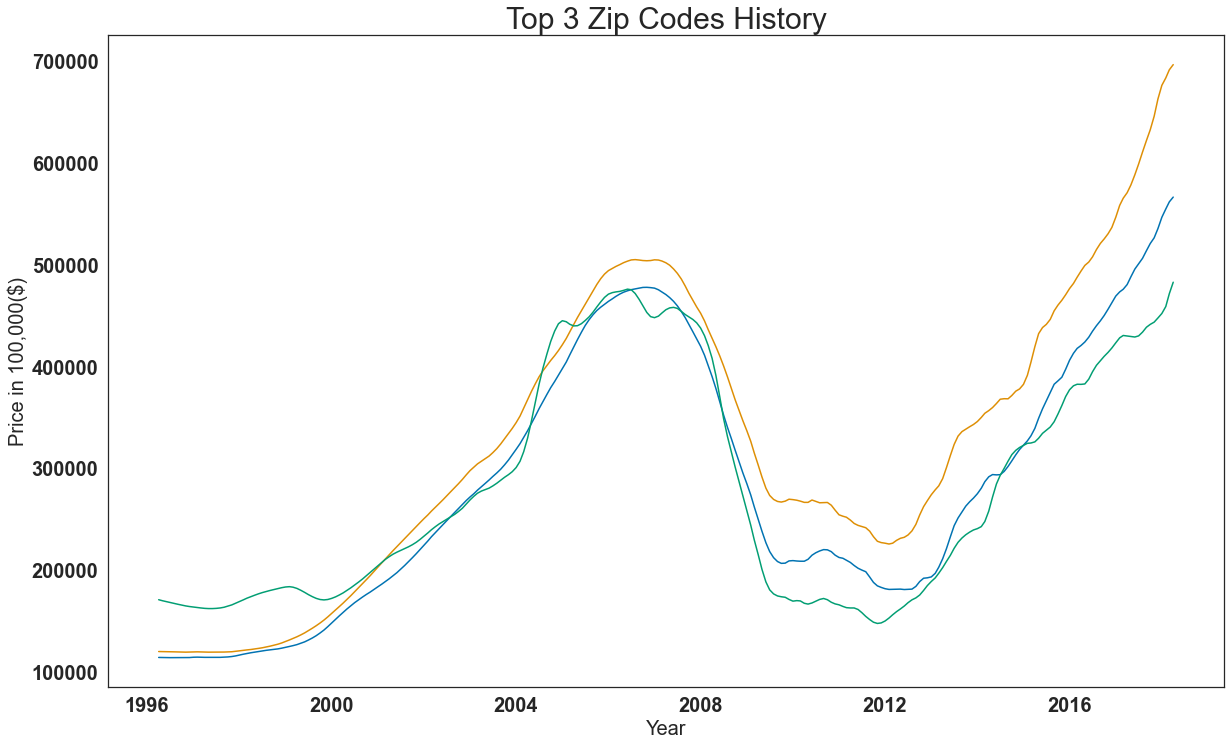

In [83]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(melted_94601)
ax.plot(melted_94604)
ax.plot(melted_94804)

ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Top 3 Zip Codes History',fontsize=30);

In [37]:
# train_set = melted_94601[:'2015-12']
# val_set = melted_94601['2016-01':]

In [38]:
melted_cali = melt_data(cali_dff1)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


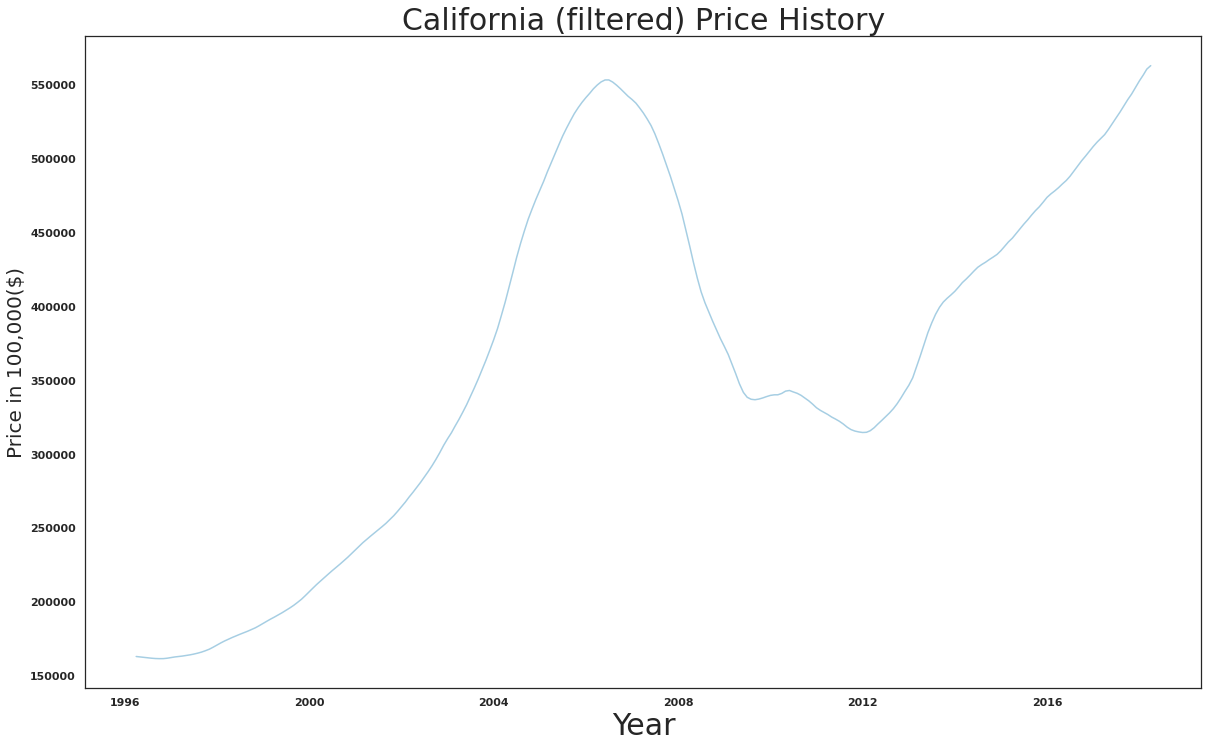

In [39]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(melted_cali)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('California (filtered) Price History',fontsize=30);

In [109]:
train_set = caliuf_melted['2010':'2016-12']
test_set = caliuf_melted['2017':]
combined = caliuf_melted['2010':]

In [110]:
# train_set = melted_cali[:'2015-12']
# test_set = melted_cali['2016-01':]

In [111]:
split = TimeSeriesSplit()
for train_ind, val_ind in split.split(train_set):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] [28 29 30 31 32 33 34 35 36 37 38 39 40 41]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41] [42 43 44 45 46 47 48 49 50 51 52 53 54 55]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55] [56 57 58 59 60 61 62 63 64 65 66 67 68 69]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69] [70 71 72 73 74 75 76 77 78 79 80 81 82 83]


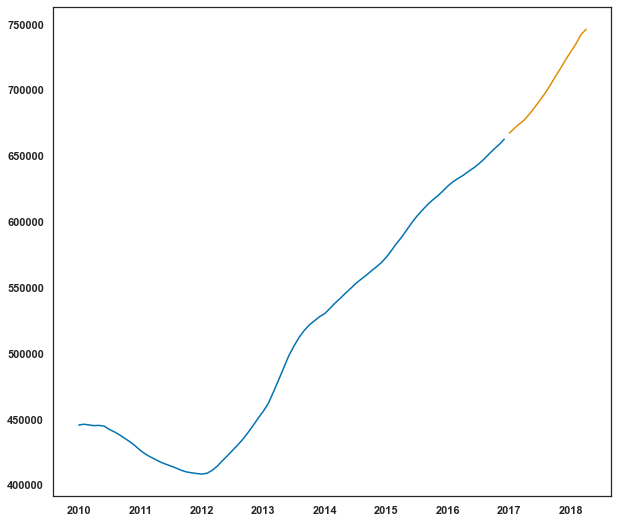

In [112]:
fig, ax = plt.subplots(figsize=(10, 9))
ax.plot(train_set, label = 'train')
ax.plot(test_set, label = 'test')

In [44]:
naive1 = train_set.shift(1)
naive2 = train_set.shift(2)
naive3 = train_set.shift(3)

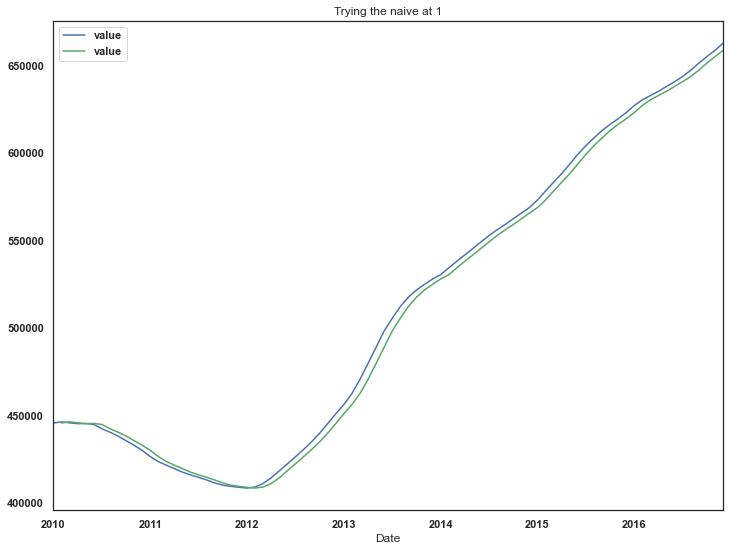

In [85]:
fig, ax = plt.subplots(figsize=(12,9))

train_set[0:400].plot(ax=ax, c = 'b', label = 'orig')
naive1[0:400].plot(ax=ax, c = 'g', label = 'naive')
ax.set_title("Trying the naive at 1")
ax.legend()

In [46]:
print(np.sqrt(mean_squared_error(train_set[3:], naive3.dropna())))
print(np.sqrt(mean_squared_error(train_set[2:], naive2.dropna())))
print(np.sqrt(mean_squared_error(train_set[1:], naive1.dropna())))

12085.368154366599
8060.444555150576
4032.720926944082


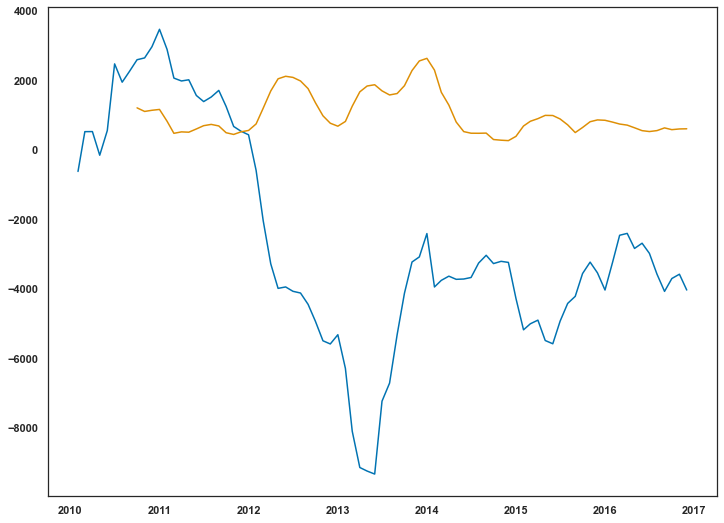

In [86]:
# Plotting Residuals
fig, ax = plt.subplots(figsize=(12,9))
residuals = naive1[1:] - train_set[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(window = 9).std())

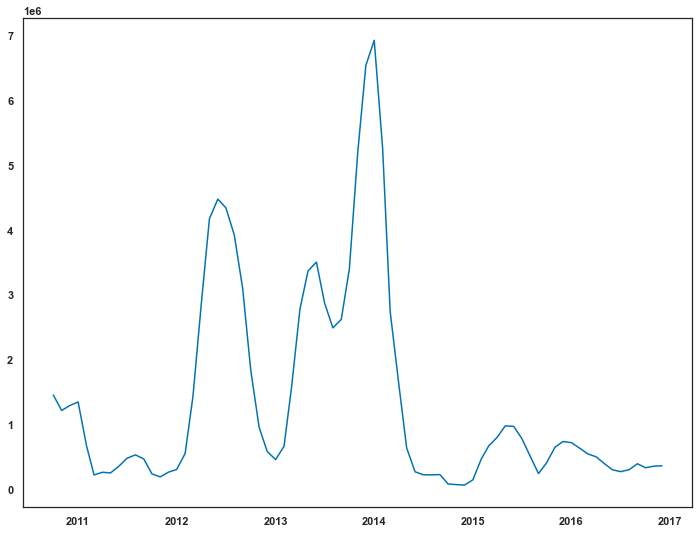

In [87]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(residuals.index, residuals.rolling(9).var())

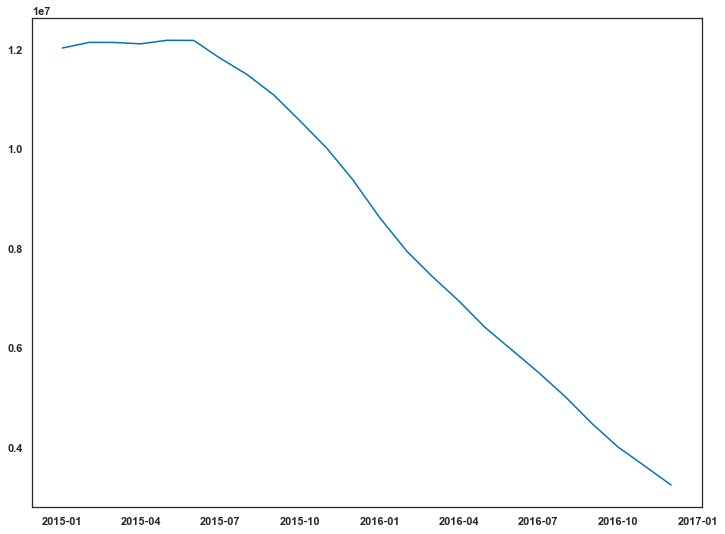

In [88]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(residuals.index, residuals.rolling(60).var())

Text(0.5, 1.0, 'Difference of training set')

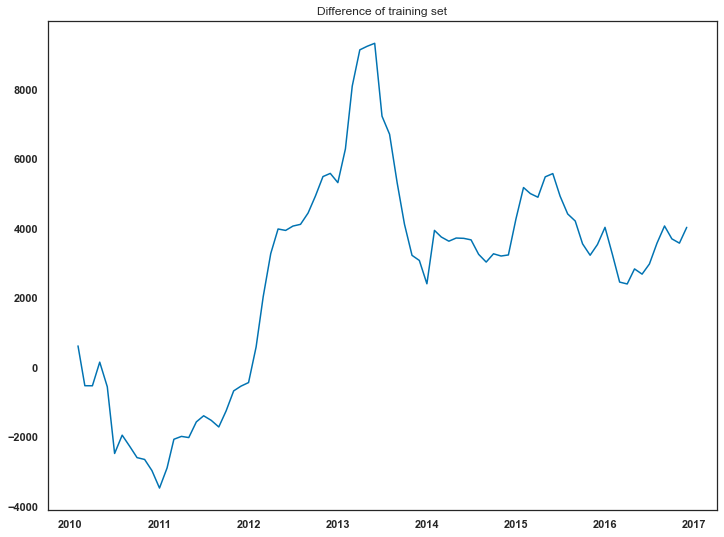

In [89]:
fig, ax = plt.subplots(figsize = (12,9))
ax.plot(train_set.diff())
ax.set_title('Difference of training set')

# Modeling

In [51]:
ar1 = ARIMA(train_set, order = (1, 1, 1)).fit()
ar1_pred = ar1.predict(typ='levels')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [52]:
# Best AIC (lowest)
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   84
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -784.430
Date:                Thu, 27 Oct 2022   AIC                           1574.860
Time:                        15:51:55   BIC                           1582.116
Sample:                    01-01-2010   HQIC                          1577.775
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.007    145.695      0.000       0.987       1.013
ma.L1         -0.9995      0.081    -12.266      0.000      -1.159      -0.840
sigma2      9.435e+06   2.64e-09   3.57e+15      0.000    9.43e+06    9.43e+06
===================================================================================
Ljung-Box (L1) (Q):                  81.16   Jarque-Bera (JB):                 1.18
Prob(Q):                              0.00   Prob(JB):                         0.55
Heteroskedasticity (H):               0.18   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.46e+30. Standard errors may be unstable.
"""

In [53]:
ar2 = ARIMA(train_set, order = (0, 1, 1)).fit()
ar2.predict(typ='levels')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2010-01-01         0.000000
2010-02-01    449407.059476
2010-03-01    446304.241481
2010-04-01    445802.683898
2010-05-01    445276.220759
                  ...      
2016-08-01    643905.908759
2016-09-01    647486.715058
2016-10-01    651563.180018
2016-11-01    655261.514961
2016-12-01    658838.726176
Freq: MS, Name: predicted_mean, Length: 84, dtype: float64

In [54]:
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   84
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -806.430
Date:                Thu, 27 Oct 2022   AIC                           1616.859
Time:                        15:51:55   BIC                           1621.697
Sample:                    01-01-2010   HQIC                          1618.803
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0088      0.013      0.703      0.482      -0.016       0.033
sigma2      1.638e+07    7.7e-12   2.13e+18      0.000    1.64e+07    1.64e+07
===================================================================================
Ljung-Box (L1) (Q):                  77.90   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.00   Prob(JB):                         0.37
Heteroskedasticity (H):               3.45   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [55]:
ar3 = ARIMA(train_set, order = (0, 1, 0)).fit()
ar3.predict(typ='levels')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2010-01-01         0.000000
2010-02-01    445710.215947
2010-03-01    446331.312292
2010-04-01    445807.059801
2010-05-01    445280.813953
                  ...      
2016-08-01    643879.901961
2016-09-01    647455.473856
2016-10-01    651527.614379
2016-11-01    655229.248366
2016-12-01    658807.516340
Freq: MS, Name: predicted_mean, Length: 84, dtype: float64

In [56]:
ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   84
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -806.857
Date:                Thu, 27 Oct 2022   AIC                           1615.714
Time:                        15:51:55   BIC                           1618.133
Sample:                    01-01-2010   HQIC                          1616.686
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.607e+07   3.17e+06      5.065      0.000    9.85e+06    2.23e+07
===================================================================================
Ljung-Box (L1) (Q):                  81.23   Jarque-Bera (JB):                 1.70
Prob(Q):                              0.00   Prob(JB):                         0.43
Heteroskedasticity (H):               3.73   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
yhat_ar1 = ar1.predict(typ='levels')
np.sqrt(mean_squared_error(train_set, yhat_ar1))

48727.1551421836

No handles with labels found to put in legend.


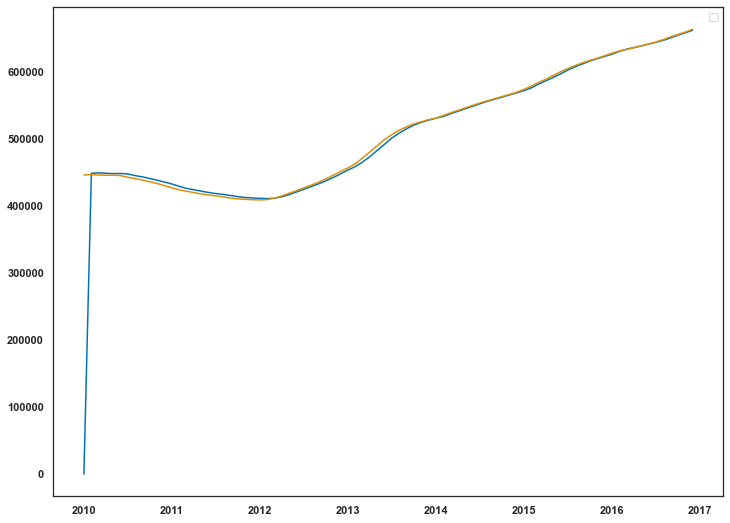

In [90]:
fig, ax = plt.subplots(figsize = (12,9))
ax.plot(ar1_pred)
ax.plot(train_set)
plt.legend(loc= 'best')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


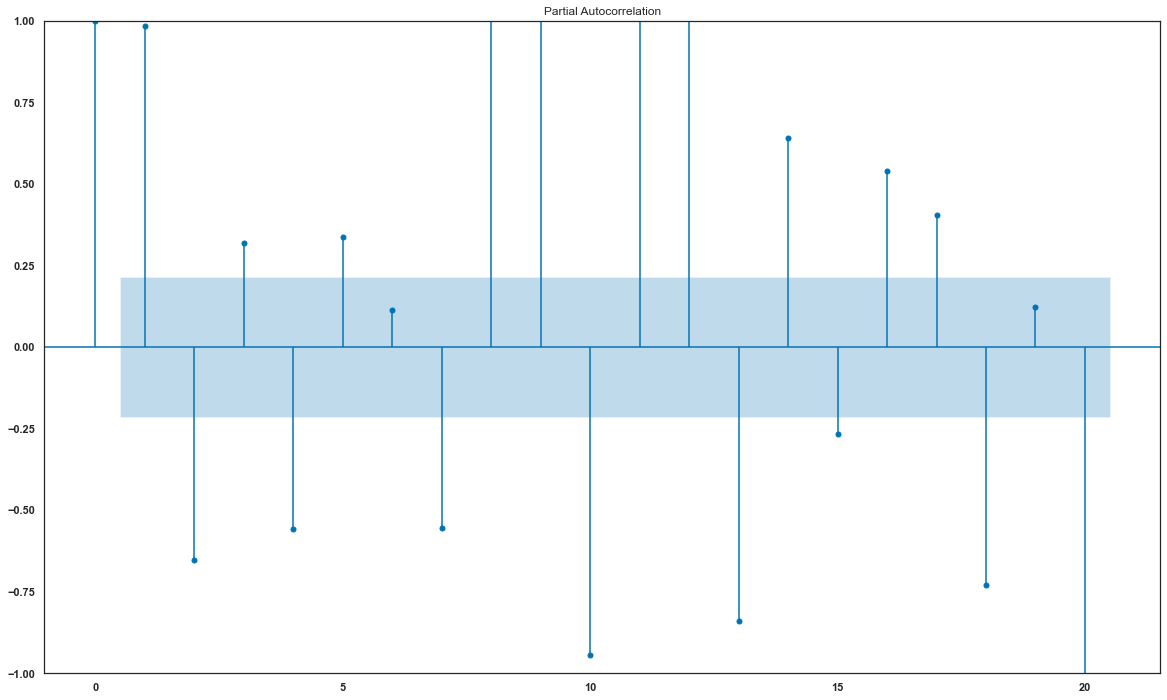

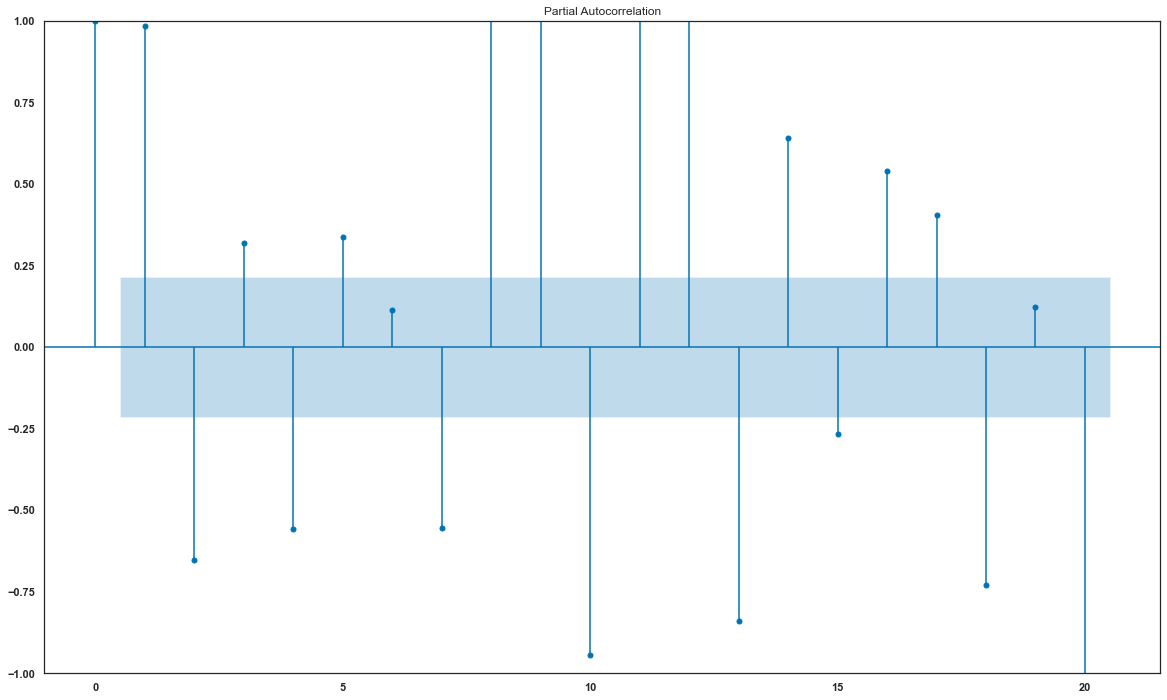

In [91]:
plot_pacf(train_set.diff().dropna())

<AxesSubplot:xlabel='Date'>

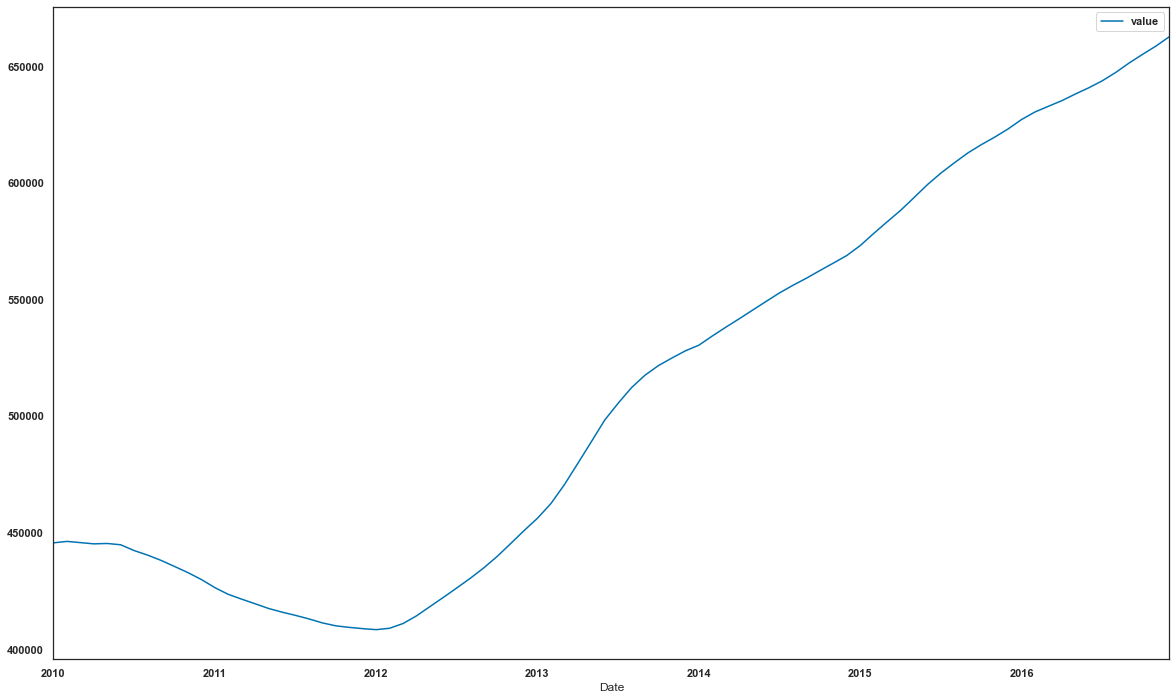

In [92]:
train_set.plot()

<AxesSubplot:xlabel='Date'>

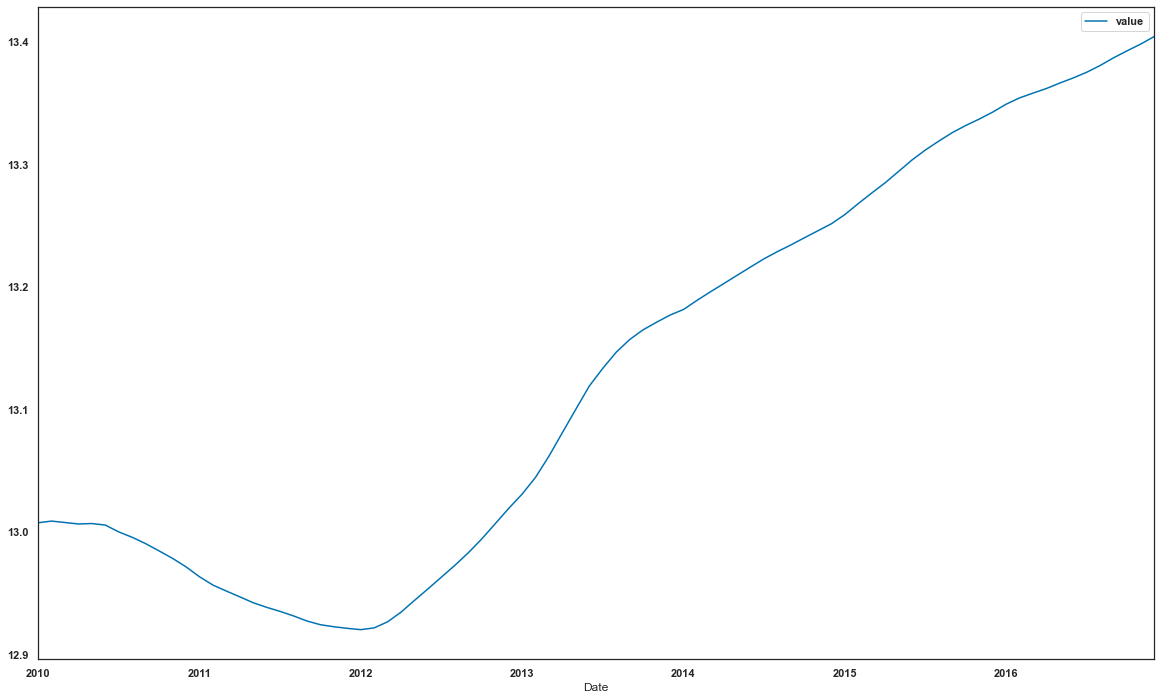

In [93]:
np.log(train_set).plot()

<AxesSubplot:xlabel='Date'>

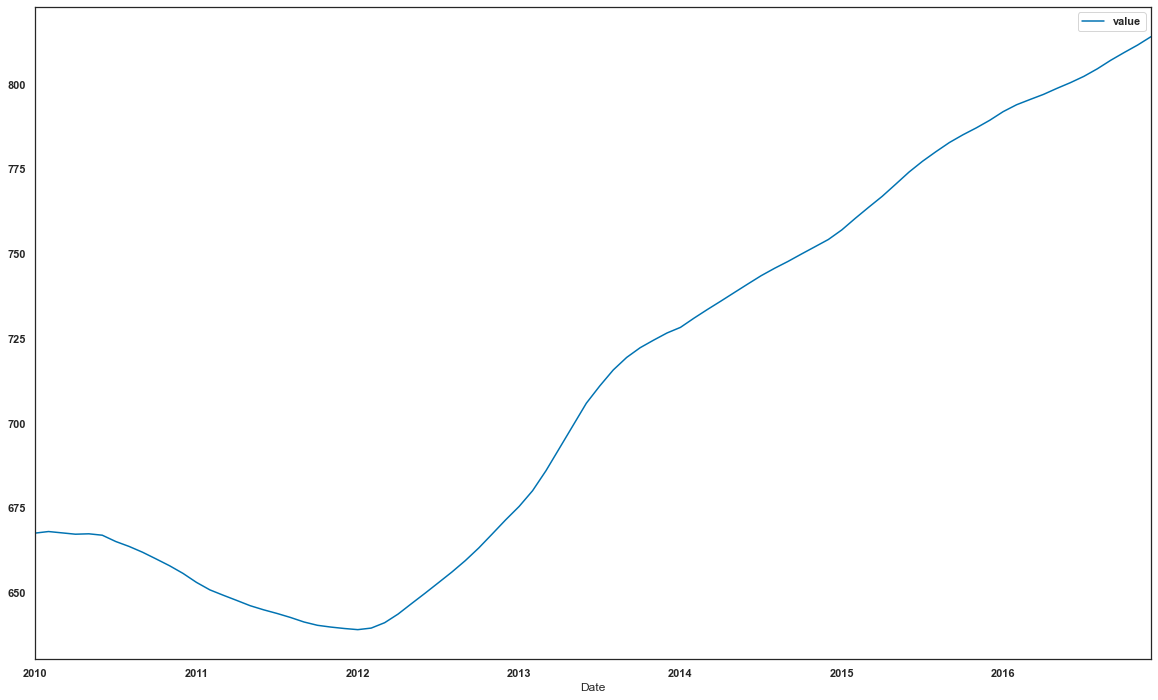

In [94]:
np.sqrt(train_set).plot()

In [95]:
decomposition = seasonal_decompose(np.log(train_set))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

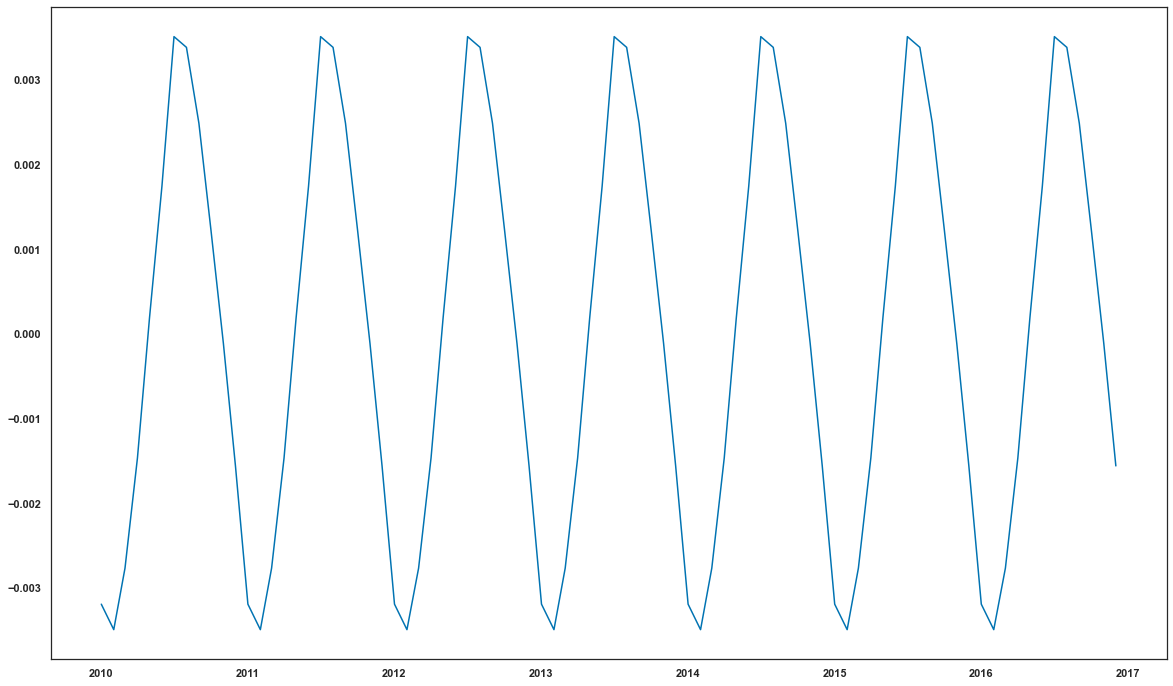

In [96]:
plt.plot(seasonal)

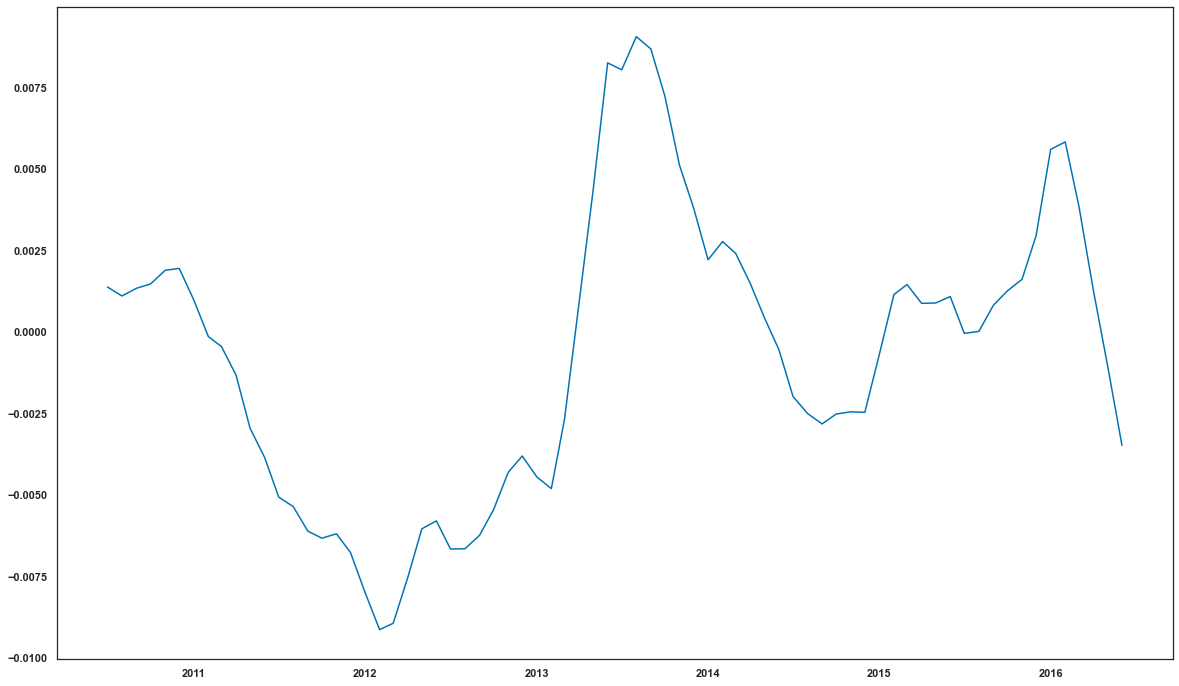

In [97]:
plt.plot(residual)

In [98]:
train_log_dec = residual
train_log_dec = train_log_dec.dropna()

In [99]:
dftest = adfuller(train_log_dec)

In [100]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                 -2.812954
p-value                         0.056447
#Lags Used                      1.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [101]:
data_transform = np.sqrt(train_set)
diff = data_transform.diff().dropna()

In [102]:
pd.DataFrame(np.hstack((data_transform[1:].values.reshape(-1, 1),diff.values.reshape(-1,1))))

,0,1
0,668.080319,0.464998
1,667.687846,-0.392473
2,667.293649,-0.394197
3,667.409207,0.115558
4,666.993552,-0.415655
...,...,...
78,804.646179,2.224905
79,807.172605,2.526426
80,809.462321,2.289715
81,811.669586,2.207265


In [103]:
adfuller(diff)

(-1.6909505444883577,
 0.4357809565327323,
 1,
 81,
 {'1%': -3.5137900174243235,
  '5%': -2.8979433868293945,
  '10%': -2.5861907285474777},
 75.61532987075933)

In [104]:
import pmdarima as pm

In [105]:
auto_model = pm.auto_arima(train_set, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)



print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2450.747, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2394.267, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1550.880, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1467.895, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2384.013, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1447.664, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2383.445, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1403.482, Time=0.19 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2385.587, Time=0.05 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=1443.204, Time=0

In [74]:
auto_model.order

(1, 0, 4)

In [75]:
auto_model.seasonal_order

(0, 0, 0, 0)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0052      0.006    157.852      0.000       0.993       1.018
ma.L1          1.4854      0.640      2.320      0.020       0.231       2.740
ma.L2          1.3792      1.010      1.366      0.172      -0.600       3.359
ma.L3          0.9938      1.069      0.929      0.353      -1.102       3.090
ma.L4          0.5376      0.739      0.728      0.467      -0.910       1.985
sigma2      4.012e+06   1.61e-07   2.49e+13      0.000    4.01e+06    4.01e+06


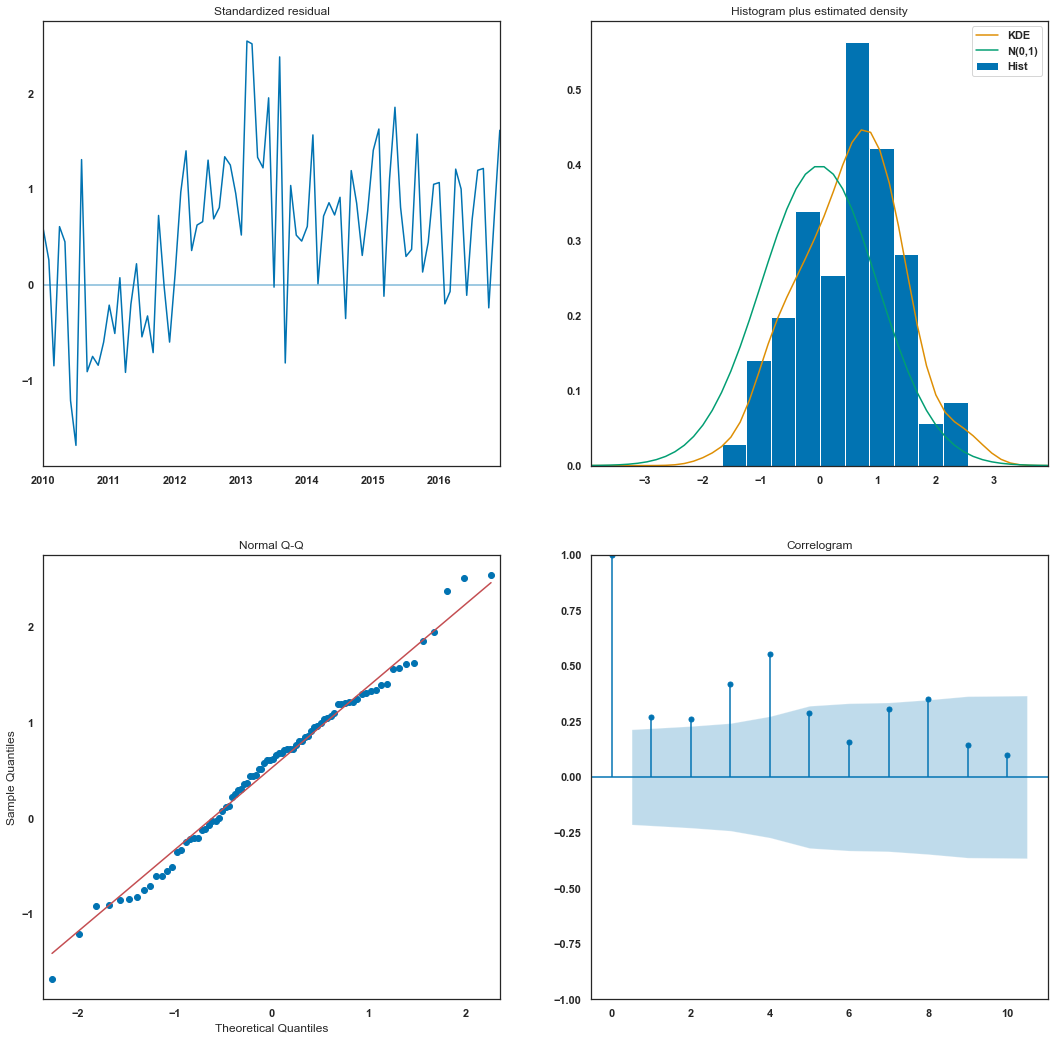

In [113]:
## MUST UPDATE ORDER AND SEASONAL ORDER EVERYTIME ANYTHING CHANGES WITH TRAINING / TEST 

ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train_set, 
                                        order=(1,0,4), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [114]:
pred = output.get_prediction(start=pd.to_datetime('2017'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower value,upper value
2017-01-01,663123.108544,670975.138676
2017-02-01,660743.483849,681817.207404
2017-03-01,657004.024775,694066.399336
2017-04-01,652739.716546,706144.394847
2017-05-01,648738.842940,717222.769636
2017-06-01,646080.503084,726995.472556
2017-07-01,644223.031808,736004.360764
2017-08-01,642914.350022,744501.706339
2017-09-01,642012.914685,752629.246314
2017-10-01,641429.920027,760475.981465


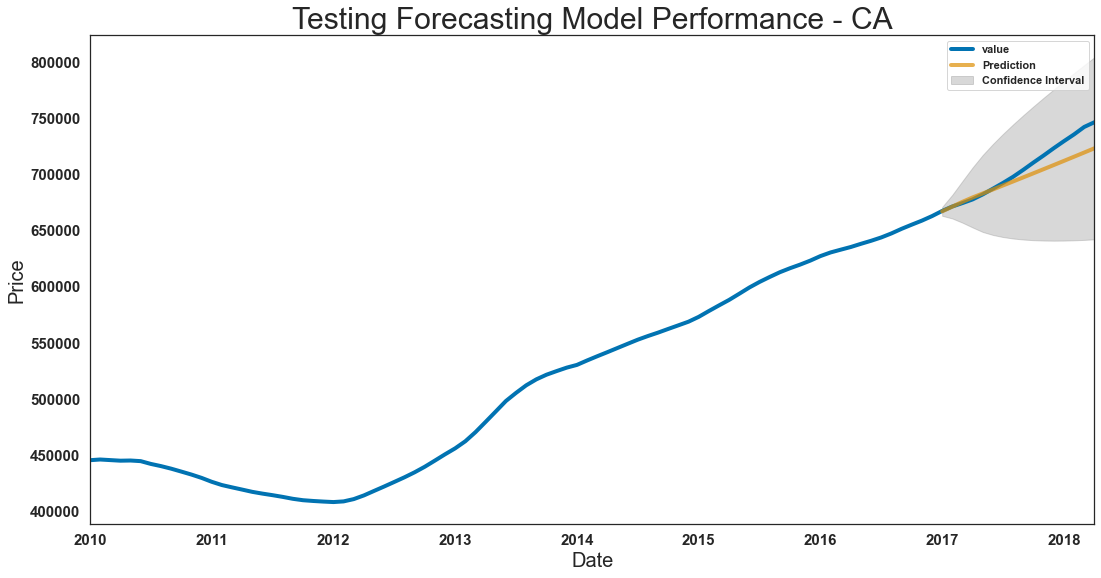

In [123]:


rcParams['figure.figsize'] = 18, 9
ax = combined.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.7, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecasting Model Performance - CA',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend()

plt.show()

In [79]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(1,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0057      0.002    434.026      0.000       1.001       1.010
ma.L1          1.0532      0.100     10.550      0.000       0.858       1.249
sigma2       7.73e+06   4.69e-10   1.65e+16      0.000    7.73e+06    7.73e+06


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [80]:
forecast = full_output.get_forecast(60)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2018-05-01,744055.438295,7.546863e+05,7.493709e+05
2018-06-01,742239.325403,7.656203e+05,7.539298e+05
2018-07-01,742819.206243,7.742137e+05,7.585164e+05
2018-08-01,744223.889808,7.820381e+05,7.631310e+05
2018-09-01,746096.222469,7.894510e+05,7.677736e+05
2018-10-01,748284.343996,7.966047e+05,7.724445e+05
2018-11-01,750706.971769,8.035806e+05,7.771438e+05
2018-12-01,753314.648143,8.104287e+05,7.818717e+05
2019-01-01,756074.677060,8.171819e+05,7.866283e+05
2019-02-01,758964.144504,8.238636e+05,7.914139e+05


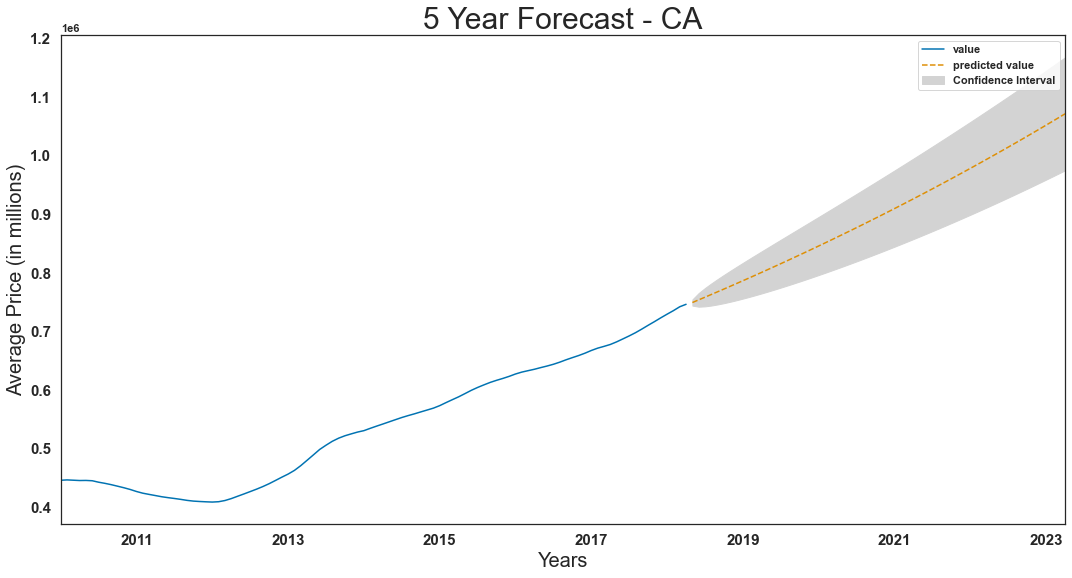

In [134]:
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Real Values')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'], color = 'lightgrey',
                label='Confidence Interval')
ax.legend()
plt.xlabel('Years', fontsize=20)
plt.ylabel("Average Price (in millions)", fontsize =20)
plt.title('5 Year Forecast - CA', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

# SARIMA

In [ ]:
import itertools
# p = q = range(0,2)
# pdq = list(itertools.product(p, [1], q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]

# for i in pdq:
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i,s))

In [ ]:
p = q = range(0,2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]

for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i,s))

In [ ]:
for param in pdq: 
    for param_seasonal in seasonal_pdq: 
        try: 
            mod=SARIMAX(train_set, 
                        order = param,
                        seasonal_order = param_seasonal,
                        enforce_stationary=False,
                        enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA {} x {} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            print ('blank')
            continue

In [ ]:
sari_mod_test1 = SARIMAX(train_set, 
                 order = (0, 1, 1,),
                 seasonal_order = (0, 1, 1, 52),
                 enforce_stationarity=False, 
                 enforce_invertibility=False).fit()

In [ ]:
sari_mod_test2 = SARIMAX(train, 
                 order = (1, 1, 1,),
                 seasonal_order = (0, 1, 1, 52),
                 enforce_stationarity=False, 
                 enforce_invertibility=False).fit()

In [ ]:
sari_mod_test3 = SARMIAX(train, 
                 order = (1, 1, 1,),
                 seasonal_order = (0, 1, 1, 60),
                 enforce_stationarity=False, 
                 enforce_invertibility=False).fit()

## California (West Coast)

In [ ]:
cali_df.isnull().sum()

In [ ]:
cali_df.isna().sum().sum()

In [ ]:
cali_df.iloc[:,7:].isnull().sum()

In [ ]:
# cali_df = cali_df.dropna(inplace=True, subset=list(cali_df.columns[216:]))
# cali_df.interpolate(inplace = True)

In [ ]:
cali_df.Zipcode = cali_df.Zipcode.astype('string')

In [ ]:
# cali_df.plot(figsize = (12,6))

In [ ]:
## 5 year ROI
cali_df['ROI_5'] = round((cali_df['2018-04'] - cali_df['2013-01'])/ cali_df['2013-01'],4)
## 3 year ROI, this metric should be the metric used
cali_df['ROI_3'] = round((cali_df['2018-04'] - cali_df['2015-01'])/ cali_df['2015-01'],4)

In [ ]:
cali_df['ROI_5']

In [ ]:
cali_df['ROI_3']

In [ ]:
cali_df.info

In [ ]:
#RWM
avg = 0
std = 10 
n_pts = 1000
date_vals = pd.date_range(starts = '04/01/1996')

In [ ]:
# def melt_data(df):
#     """
#     Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
#     Returns a long-form datetime dataframe 
#     with the datetime column names as the index and the values as the 'values' column.
    
#     If more than one row is passes in the wide-form dataset, the values column
#     will be the mean of the values from the datetime columns in all of the rows.
#     """
    
#     melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('time').aggregate({'value':'mean'})